<a href="https://colab.research.google.com/github/aanilkumarreddy/DataDiggers/blob/main/ARIMA_NFLX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
df1 = pd.read_csv('NFLX.csv')
stock=df1

In [4]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200


In [5]:
stock['Date'].min()

'2018-01-02'

In [6]:
stock['Date'].max()

'2021-12-30'

In [7]:
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')

In [8]:
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
stock.drop(cols, axis=1, inplace=True)
stock = stock.sort_values('Date')

In [9]:
stock.isnull().sum()

Date     0
Close    0
dtype: int64

In [10]:
stock = stock.groupby('Date')['Close'].sum().reset_index()

In [11]:
stock.head()

,Date,Close
0,2018-01-02,201.070007
1,2018-01-03,205.050003
2,2018-01-04,205.630005
3,2018-01-05,209.990005
4,2018-01-08,212.050003


In [12]:
stock = stock.set_index('Date')
stock.index

Index(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-08',
       '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-16',
       ...
       '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
       '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30'],
      dtype='object', name='Date', length=1007)

In [13]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.Close.resample('M').mean()

In [14]:
monthly_mean['2018':]

Date
2018-01-31    232.908096
2018-02-28    271.443683
2018-03-31    312.228097
2018-04-30    307.466192
2018-05-31    331.536819
2018-06-30    384.133336
2018-07-31    381.515238
2018-08-31    346.257824
2018-09-30    362.641576
2018-10-31    335.445652
2018-11-30    290.344764
2018-12-31    265.302630
2019-01-31    325.814287
2019-02-28    355.607896
2019-03-31    359.435712
2019-04-30    366.145714
2019-05-31    359.450000
2019-06-30    356.615999
2019-07-31    350.781816
2019-08-31    303.128179
2019-09-30    281.945499
2019-10-31    277.636520
2019-11-30    299.125499
2019-12-31    314.603809
2020-01-31    338.832857
2020-02-29    373.988422
2020-03-31    350.587271
2020-04-30    404.310951
2020-05-31    433.294000
2020-06-30    438.977728
2020-07-31    499.385003
2020-08-31    498.074762
2020-09-30    495.553333
2020-10-31    515.141814
2020-11-30    487.444000
2020-12-31    516.569090
2021-01-31    526.816845
2021-02-28    548.959999
2021-03-31    518.123482
2021-04-30    533.13

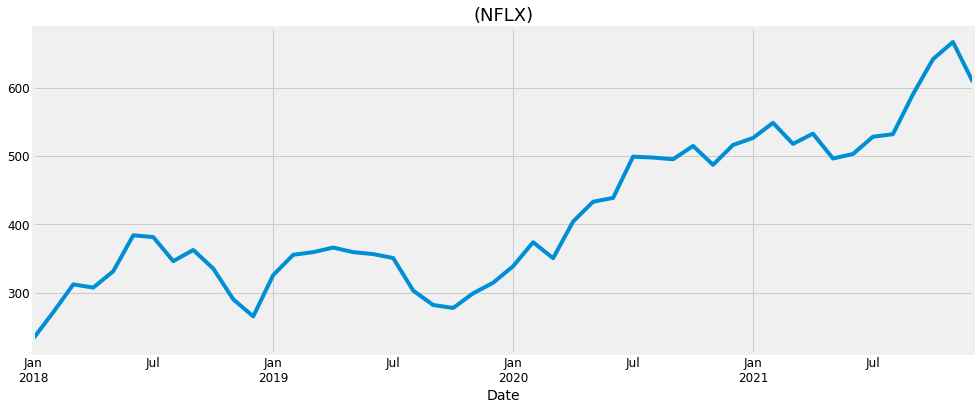

In [16]:
monthly_mean.plot(figsize=(15, 6))
plt.title('(NFLX)', fontsize=18)
plt.show()

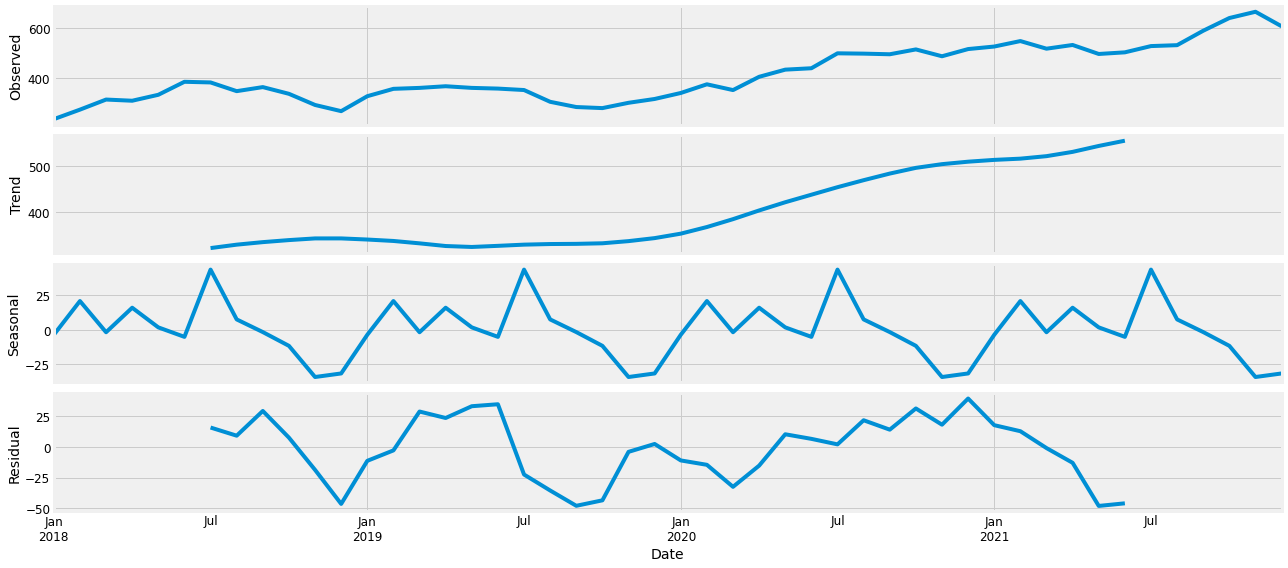

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:705.4612443647213


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1253.9561807123616
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:433.9364064397056
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:426.9081144180527
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1465.6251368280034
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:305.50943480803073
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:635.033706958429


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:387.8506127497386
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:396.9320129236609
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2684.2887967491133


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:280.9964760370427
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:448.0666588181743
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1081.8720407039214
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:347.8698305927822
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:339.1219594531925


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1191.4007183956792
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:236.32333659257705
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:438.7068879541206


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1128.9782198349742
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:338.7675623535796
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:340.67641216912443


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1047.713675424472
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:238.1347500832977
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:457.99148086303285


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1545.3610591672984
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:358.0871897862625
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:339.40552051237376


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1455.6095038414253
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:238.3084684573405
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:449.71101765028305


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1526.8904151119987
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:349.35759338872236
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:341.3617173451183


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1419.9922765752742
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:240.05949528000022
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:448.64230735176346


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1204.8630120867444
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:348.60504529268565
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:331.2641522507246
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1232.1412107455988
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:228.95535151791245
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:440.68478514799045


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1234.6817860789954
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:340.59326787990733
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:333.0903907998862
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1156.8183569645382
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:230.87368473687746


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [20]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [21]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1191      0.283      0.420      0.674      -0.436       0.674
ar.S.L12      -0.3637      0.318     -1.143      0.253      -0.987       0.260
sigma2      1476.6931    571.089      2.586      0.010     357.380    2596.007


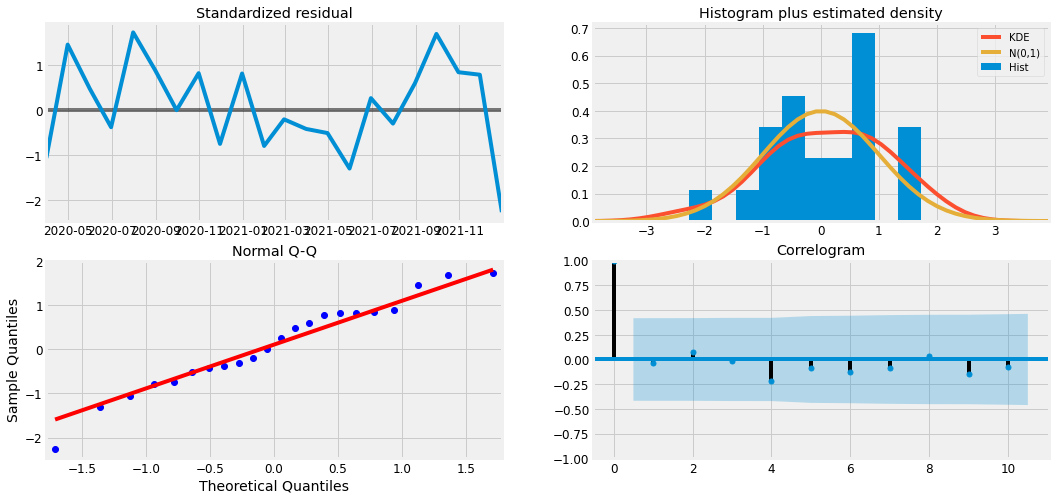

In [22]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

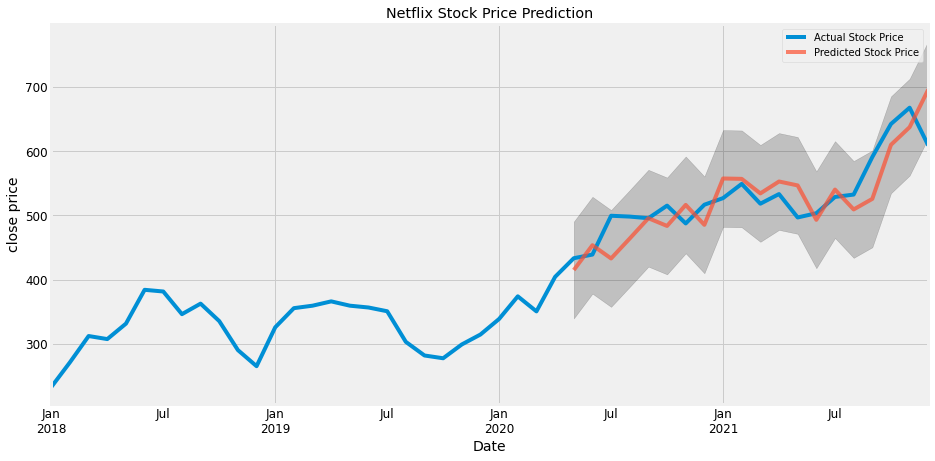

In [38]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthly_mean['2018':].plot(label='Actual Stock Price')
pred.predicted_mean.plot(ax=ax, label='Predicted Stock Price', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.title('Netflix Stock Price Prediction')
plt.show()

In [24]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1381.85


In [25]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 37.17


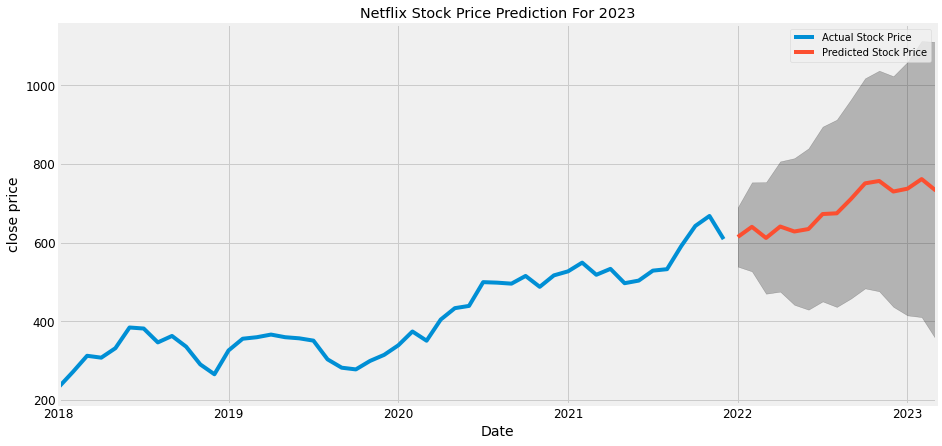

In [39]:
pred_uc = results.get_forecast(steps=15)
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='Actual Stock Price', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Predicted Stock Price')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.title('Netflix Stock Price Prediction For 2023')
plt.legend()
plt.show()